<a href="https://colab.research.google.com/github/skumbham/PPE-Detection-Using-Yolo11/blob/main/Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Required Installations apart from what already present in Colab

!pip install roboflow
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.6 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 877.1/877.1 kB 48.9 MB/s eta 0:00:00


In [2]:
# Keeping the Code Clean

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Import the Dataset from Roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="zBx9nLSC08D5wkJpQVQW")
project = rf.workspace("roboflow-universe-projects").project("construction-site-safety")
version = project.version(28)
dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Construction-Site-Safety-28 in yolov11:: 100%|██████████| 5614/5614 [00:01<00:00, 5481.97it/s]


# **EDA**



In [5]:
import yaml
import os

# Load the YAML file
yaml_path = 'Construction-Site-Safety-28/data.yaml'
with open(yaml_path, 'r') as file:
  data = yaml.safe_load(file)

# Extract class names
class_names = data['names']

# Paths to the directories containing the YOLO annotations
train_annotations_path = 'Construction-Site-Safety-28/train/labels'
val_annotations_path = 'Construction-Site-Safety-28/valid/labels'
test_annotations_path = 'Construction-Site-Safety-28/test/labels'

# Define paths to the image directories
base_path = 'Construction-Site-Safety-28'
train_images_path = os.path.join(base_path, 'train/images')
val_images_path = os.path.join(base_path, 'valid/images')
test_images_path = os.path.join(base_path, 'test/images')

In [8]:
# Count of Images
def count_images(images_path):
  return len([f for f in os.listdir(images_path) if f.endswith(('.png', '.jpg', '.jpeg'))])

train_count = count_images(train_images_path)
val_count = count_images(val_images_path)
test_count = count_images(test_images_path)
total_count = train_count + val_count + test_count

print(f"Total number of images: {total_count}")
print(f"Number of training images: {train_count}")
print(f"Number of validation images: {val_count}")
print(f"Number of test images: {test_count}")

Total number of images: 2801
Number of training images: 2605
Number of validation images: 114
Number of test images: 82


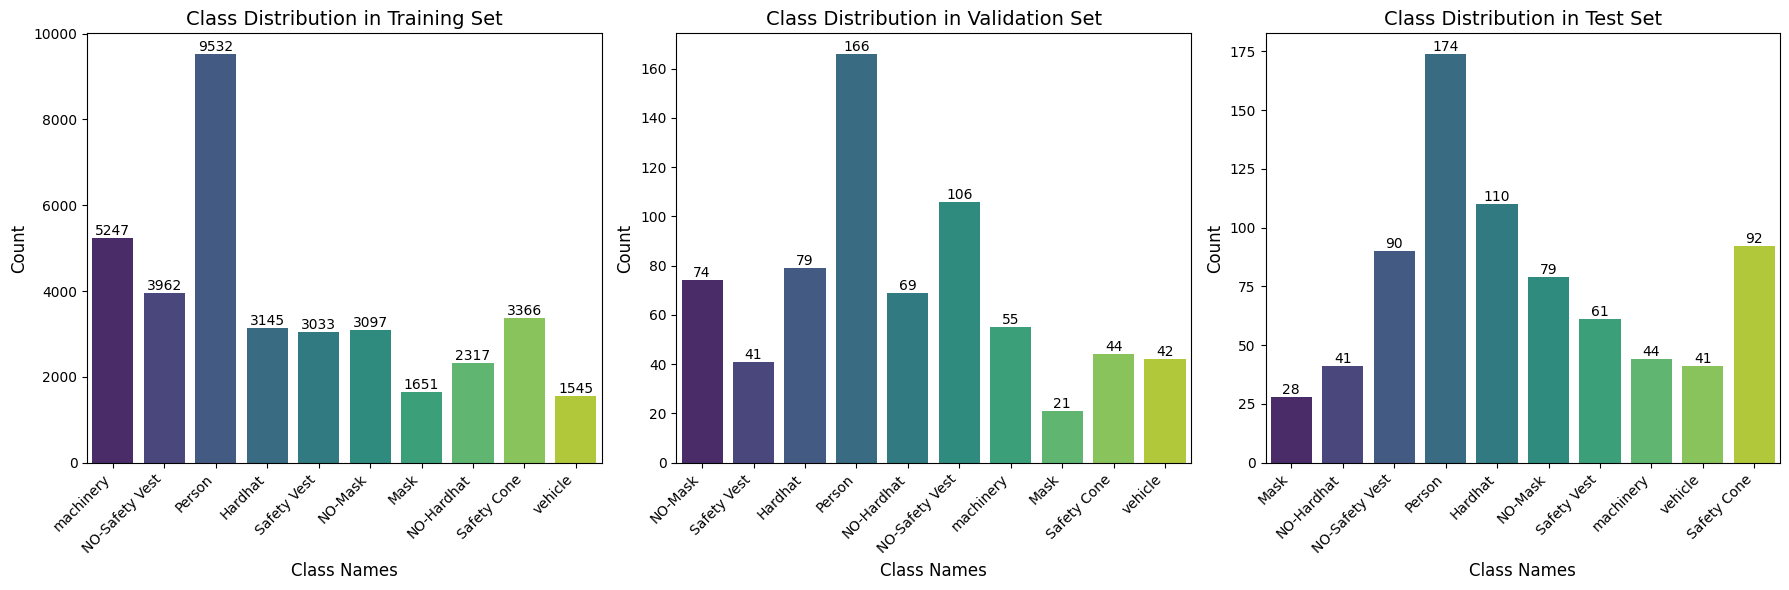

In [25]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Function to count the classes in the YOLO annotation files
def count_classes(annotations_path, class_names):
    class_counter = Counter()

    for label_file in os.listdir(annotations_path):
        if label_file.endswith('.txt'):
            file_path = os.path.join(annotations_path, label_file)
            with open(file_path, 'r') as file:
                for line in file:
                    class_id = int(line.split()[0])
                    class_counter[class_names[class_id]] += 1

    return class_counter

# Function to handle subplots
def plot_class_distribution_subplot(ax, class_counts, dataset_type):
    bars = sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="viridis", ax=ax)
    ax.set_title(f'Class Distribution in {dataset_type} Set', fontsize=14)
    ax.set_xlabel('Class Names', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

    # Annotate bars with the actual count values
    for bar in bars.patches:
        bar_height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, bar_height, f'{int(bar_height)}', ha='center', va='bottom', fontsize=10)

train_class_counts = count_classes(train_annotations_path, class_names)
val_class_counts = count_classes(val_annotations_path, class_names)
test_class_counts = count_classes(test_annotations_path, class_names)

# Plot
fig, axs = plt.subplots(1, 3, figsize=(18,6))
plot_class_distribution_subplot(axs[0], train_class_counts, 'Training')
plot_class_distribution_subplot(axs[1], val_class_counts, 'Validation')
plot_class_distribution_subplot(axs[2], test_class_counts, 'Test')

# Adjust layout
plt.tight_layout()
plt.show()


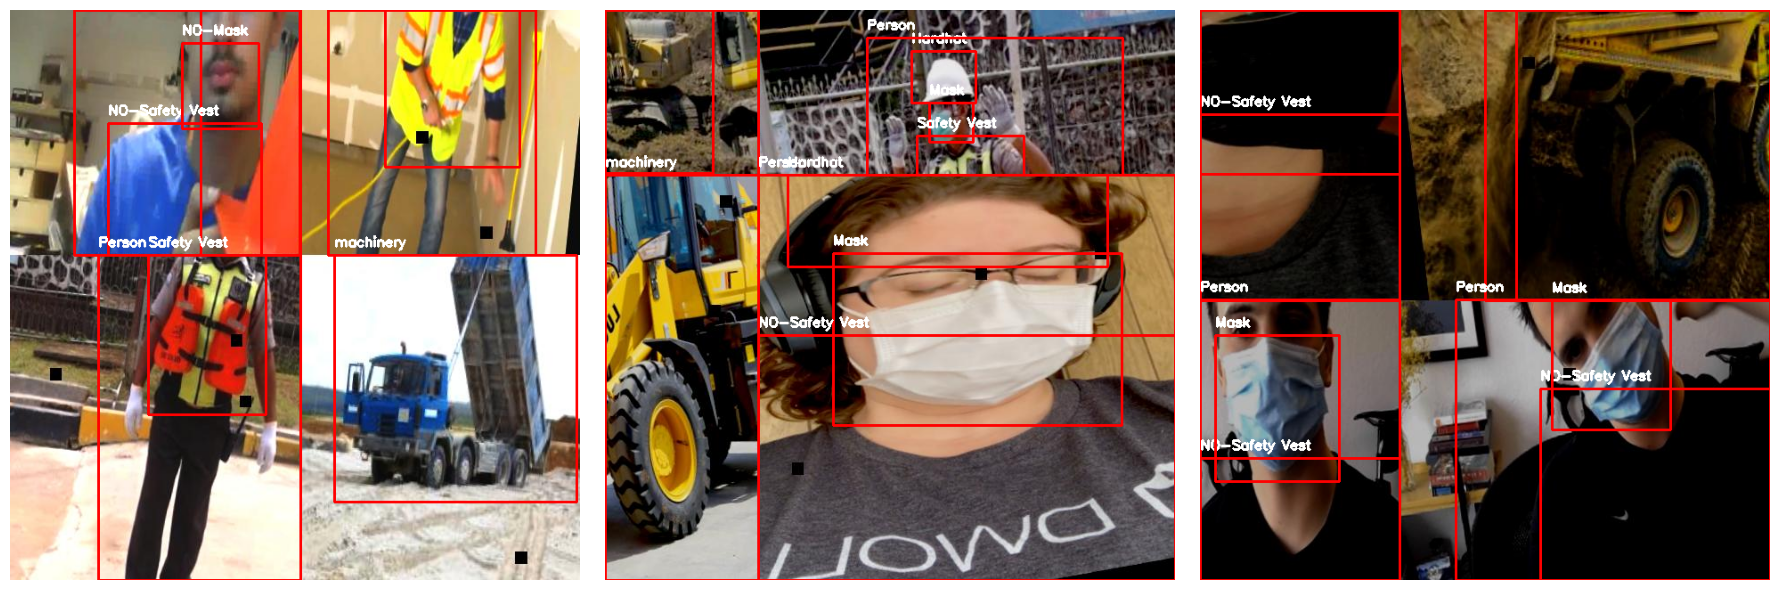

In [26]:
import cv2
import random

# Display images with bounding boxes and annotated labels from YOLO format
def display_images_with_boxes(images_path, annotations_path, class_names, num_images=3):
    selected_images = random.sample([f for f in os.listdir(images_path) if f.endswith(('.png', '.jpg', '.jpeg'))], num_images)
    fig, axs = plt.subplots(1, num_images, figsize=(18, 6))

    for i, image_file in enumerate(selected_images):
        # Load the image
        image = cv2.cvtColor(cv2.imread(os.path.join(images_path, image_file)), cv2.COLOR_BGR2RGB)

        # Read bounding boxes and draw them
        with open(os.path.join(annotations_path, os.path.splitext(image_file)[0] + '.txt')) as file:
            for line in file:
                class_id, x_center, y_center, bbox_width, bbox_height = map(float, line.split())
                x1, y1 = int((x_center - bbox_width / 2) * image.shape[1]), int((y_center - bbox_height / 2) * image.shape[0])
                x2, y2 = int((x_center + bbox_width / 2) * image.shape[1]), int((y_center + bbox_height / 2) * image.shape[0])
                cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
                cv2.putText(image, class_names[int(class_id)], (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

        axs[i].imshow(image)
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

# Call the function to display three images with bounding boxes and labels
display_images_with_boxes(train_images_path, train_annotations_path, class_names, num_images=3)


In [28]:
# Import the Pre-Trained Model
from ultralytics import YOLO
model = YOLO("yolo11n.pt")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 5.35M/5.35M [00:00<00:00, 15.5MB/s]


In [29]:
# Training the Model
results = model.train(data="/content/Construction-Site-Safety-28/data.yaml", epochs=20, device=0, plots=True)

Ultralytics 8.3.21 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/content/Construction-Site-Safety-28/data.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf

100%|██████████| 755k/755k [00:00<00:00, 85.7MB/s]


Overriding model.yaml nc=80 with nc=10

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytic

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅


train: Scanning /content/Construction-Site-Safety-28/train/labels... 2605 images, 6 backgrounds, 0 corrupt: 100%|██████████| 2605/2605 [00:01<00:00, 1487.73it/s]

train: WARNING ⚠️ /content/Construction-Site-Safety-28/train/images/004720_jpg.rf.afc486560a4004c7cfd67910af31a29c.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/Construction-Site-Safety-28/train/images/construction-813-_jpg.rf.b085952261fd98f2e76b8065de149b5f.jpg: 1 duplicate labels removed


train: New cache created: /content/Construction-Site-Safety-28/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/Construction-Site-Safety-28/valid/labels... 114 images, 10 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<00:00, 576.72it/s]

val: New cache created: /content/Construction-Site-Safety-28/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      3.27G        1.4      3.181      1.482        306        640: 100%|██████████| 163/163 [01:02<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]

                   all        114        697      0.378      0.349      0.313      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      3.88G      1.321      1.973      1.449        244        640: 100%|██████████| 163/163 [00:58<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.32it/s]

                   all        114        697      0.568      0.428      0.457       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      3.45G      1.275      1.704       1.41        346        640: 100%|██████████| 163/163 [00:58<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.67it/s]

                   all        114        697      0.633      0.447      0.485      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      3.84G      1.242      1.595      1.385        313        640: 100%|██████████| 163/163 [00:58<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.07it/s]

                   all        114        697      0.667      0.499      0.532      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      3.52G      1.217      1.514      1.365        316        640: 100%|██████████| 163/163 [00:58<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.79it/s]

                   all        114        697      0.689      0.513      0.563      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      3.26G      1.186      1.451      1.343        251        640: 100%|██████████| 163/163 [00:57<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.83it/s]

                   all        114        697      0.641      0.493      0.522      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      3.26G      1.157      1.377       1.32        222        640: 100%|██████████| 163/163 [00:59<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.85it/s]

                   all        114        697       0.66      0.537      0.576      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20       3.7G      1.146      1.329       1.31        246        640: 100%|██████████| 163/163 [00:58<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.78it/s]

                   all        114        697      0.641      0.561      0.577       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      3.68G      1.125      1.286      1.294        441        640: 100%|██████████| 163/163 [00:58<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]

                   all        114        697      0.769      0.576      0.638      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      3.43G      1.108      1.243      1.282        290        640: 100%|██████████| 163/163 [00:58<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.64it/s]

                   all        114        697      0.727      0.575      0.619      0.298


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      3.07G      1.149      1.212      1.316        132        640: 100%|██████████| 163/163 [00:57<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.84it/s]

                   all        114        697      0.766      0.616      0.662      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      3.06G      1.114      1.136       1.29        154        640: 100%|██████████| 163/163 [00:56<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.69it/s]

                   all        114        697      0.801      0.594      0.661      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      3.26G      1.096      1.092      1.275        247        640: 100%|██████████| 163/163 [00:54<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.57it/s]

                   all        114        697      0.806      0.622      0.686       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.84G      1.074      1.049      1.261        152        640: 100%|██████████| 163/163 [00:55<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.35it/s]

                   all        114        697      0.835      0.624       0.69      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      3.05G      1.051      1.014      1.245        147        640: 100%|██████████| 163/163 [00:55<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.80it/s]

                   all        114        697      0.828      0.633      0.704      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      3.27G      1.031     0.9745      1.231        126        640: 100%|██████████| 163/163 [00:55<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.83it/s]

                   all        114        697      0.841      0.655      0.722      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      3.07G      1.009      0.948      1.213        256        640: 100%|██████████| 163/163 [00:54<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.91it/s]

                   all        114        697      0.849      0.643      0.709      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.93G     0.9968     0.9233      1.202        124        640: 100%|██████████| 163/163 [00:59<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.12it/s]

                   all        114        697      0.869      0.646      0.724      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      3.14G      0.973     0.8952       1.19        159        640: 100%|██████████| 163/163 [00:54<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.98it/s]

                   all        114        697      0.892      0.647      0.727      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      3.04G     0.9615     0.8857      1.182        116        640: 100%|██████████| 163/163 [00:54<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.72it/s]

                   all        114        697      0.881      0.648      0.733      0.413



20 epochs completed in 0.333 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.21 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11n summary (fused): 238 layers, 2,584,102 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


                   all        114        697      0.883      0.649      0.734      0.413
               Hardhat         42         79      0.948      0.709       0.82      0.533
                  Mask         19         21          1      0.825      0.858      0.499
            NO-Hardhat         37         69       0.86      0.478      0.572      0.259
               NO-Mask         44         74      0.898      0.446      0.593      0.247
        NO-Safety Vest         56        106        0.9      0.575      0.684      0.361
                Person         84        166      0.854      0.669      0.798      0.483
           Safety Cone         13         44       0.94      0.886      0.892      0.483
           Safety Vest         28         41      0.936      0.707       0.82      0.472
             machinery         26         55      0.881      0.811      0.871      0.548
               vehicle         16         42      0.615      0.381      0.429      0.247
Speed: 0.3ms preproce

lr/pg0,▃▆██▇▇▆▆▆▅▅▄▄▃▃▃▂▂▁▁
lr/pg1,▃▆██▇▇▆▆▆▅▅▄▄▃▃▃▂▂▁▁
lr/pg2,▃▆██▇▇▆▆▆▅▅▄▄▃▃▃▂▂▁▁
metrics/mAP50(B),▁▃▄▅▅▄▅▅▆▆▇▇▇▇██████
metrics/mAP50-95(B),▁▂▄▄▄▄▅▄▆▅▆▆▆▆▇█▇█▇█
metrics/precision(B),▁▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇▇███
metrics/recall(B),▁▃▃▄▅▄▅▆▆▆▇▇▇▇▇█████
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,█▇▆▅▅▅▄▄▄▃▄▃▃▃▂▂▂▂▁▁


# **Citations and Acknowledgements**

```
@software{yolo11_ultralytics,
  author = {Glenn Jocher and Jing Qiu},
  title = {Ultralytics YOLO11},
  version = {11.0.0},
  year = {2024},
  url = {https://github.com/ultralytics/ultralytics},
  orcid = {0000-0001-5950-6979, 0000-0002-7603-6750, 0000-0003-3783-7069},
  license = {AGPL-3.0}
}
```

